In [2]:
from collections import namedtuple
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
import math
from sklearn.decomposition import PCA
import random
from sklearn.decomposition import PCA
import random

In [3]:
Point = namedtuple('Point', ['x', 'y']) # Making each data point a tuple

class Cluster: # Creating the Cluster class
    def __init__(self, label, center: Point): # Initialising values
        self.label = label
        self.center = (center.x, center.y)
        self.wcss = 0.0
        self.points_index = []

    def get_label(self):
        return self.label
    
    def get_center(self):
        return self.center
    
    def get_wcss(self):
        return self.wcss
    
    def get_points(self):
        return self.points_index

    def set_center(self, new_center):
        self.center = new_center

    def add_point(self, point):
        self.points_index.append(point)
        dx = point.x - self.center[0]
        dy = point.y - self.center[1]
        # accumulate squared distance
        self.wcss += dx*dx + dy*dy
    
    def reset_points(self):
        self.points_index = []
        self.wcss = 0.0

    def update_wcss(self, update_val):
        self.wcss = update_val

In [4]:
def k_means(dataset, clusters):
    #Assign random points as cluster centers to begin
    #Calculate distance from each center and assign to closest center
    def assign_point_to_cluster(point):
        closest_cluster = None
        current_closest_distance = float('inf')
        for cluster in clusters:
            point_cluster_distance = math.sqrt((point.y - cluster.get_center()[1])**2 + (point.x - cluster.get_center()[0])**2)
            if point_cluster_distance < current_closest_distance:
                closest_cluster = cluster
                current_closest_distance = point_cluster_distance
        closest_cluster.add_point(point)
    
    def recalculate_cluster_center(cluster):
        tolerance = 3
        total_x = 0
        total_y = 0
        for point in cluster.get_points():
            total_x += point.x
            total_y += point.y
        new_center = (total_x/len(cluster.get_points()), total_y/len(cluster.get_points()))
        if (new_center != cluster.get_center()) or ((new_center[0] > cluster.get_center()[0] + tolerance) and (new_center[1] > cluster.get_center()[1] + tolerance)):
            cluster.set_center(new_center)
            return True
        else:
            return False

    all_centers_unchanged = False
    cluster_change_list = []

    while not all_centers_unchanged:
        cluster_change_list = []
        for point in dataset:
            assign_point_to_cluster(point)

        for cluster in clusters:
            cluster_change_list.append(recalculate_cluster_center(cluster))
            cluster.reset_points()

        if True in cluster_change_list:
            cluster_change_list = []
        else:
            all_centers_unchanged = True

    cluster_labels = []

    for point in dataset:
        closest_cluster = None
        min_dist = float('inf')
        for cluster in clusters:
            dx = point.x - cluster.get_center()[0]
            dy = point.y - cluster.get_center()[1]
            dist = dx**2 + dy**2
            if dist < min_dist:
                min_dist = dist
                closest_cluster = cluster
        closest_cluster.add_point(point)
        cluster_labels.append(closest_cluster.get_label())

    return clusters, cluster_labels

In [5]:
def min_max_scaling(df, column):
    min = df[column].min() # Getting the min value in the col
    max = df[column]. max() # Getting the max value in the col

    def func(x):
        return (((x-min)/(max-min))) # Calculating min-max formula

    df[column] = df[column].apply(func) # Applying formula to all values in the column

In [6]:
def get_total_wcss(dataset, clusters_list):
    total_wcss = 0
    clusters, c_list = k_means(dataset, clusters_list)
    for cluster in clusters:
        total_wcss += cluster.get_wcss()
    return total_wcss

In [7]:
df = pd.read_csv("IRIS.csv")
df['sepal_length'] = pd.to_numeric(df['sepal_length'], errors='coerce')
df['sepal_width'] = pd.to_numeric(df['sepal_width'], errors='coerce')
df['petal_length'] = pd.to_numeric(df['petal_length'], errors='coerce')
df['petal_width'] = pd.to_numeric(df['petal_width'], errors='coerce')

new_df = df

new_df = new_df.drop(columns=['species'])

for column in new_df.columns[0:]: # Iterate over each column
    min_max_scaling(new_df, column) # Apply min-max to each column

new_df.head()

,sepal_length,sepal_width,petal_length,petal_width
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667


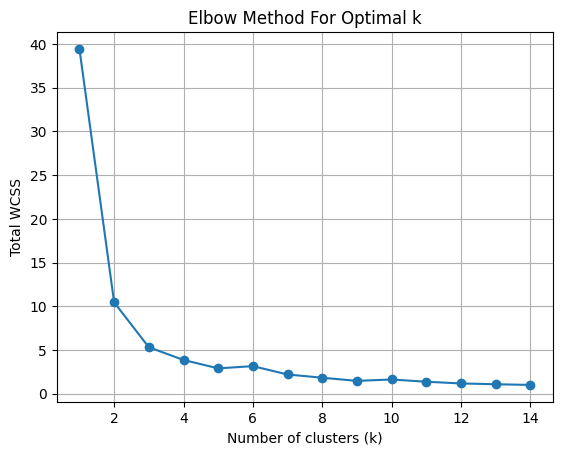

In [8]:
pca = PCA(n_components=2)  # Reduce to 2D for visualization
reduced_data = pca.fit_transform(new_df)

# Pick 15 distinct points as initial centers
initial_centers = random.sample(list(reduced_data), 15)

# Build your clusters
clusters = [
    Cluster(label=i, center=Point(x=center[0], y=center[1]))
    for i, center in enumerate(initial_centers)
]

running_total = []
for k in range(1, 15):
    centers_k = random.sample(list(reduced_data), k)
    clusters_k = [Cluster(label=i, center=Point(x=centers_k[i][0], y=centers_k[i][1])) for i in range(k)]

    wcss_k = get_total_wcss([Point(x, y) for x, y in reduced_data], clusters_k)
    running_total.append(wcss_k)

plt.plot(range(1, 15), running_total, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Total WCSS')
plt.grid(True)
plt.show()

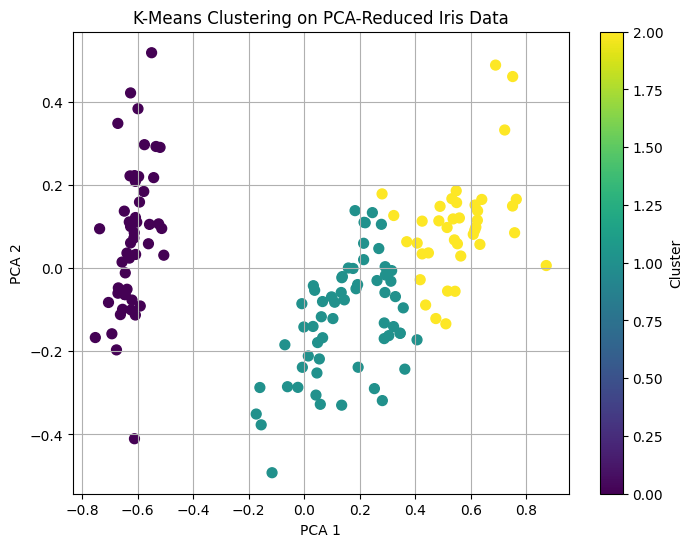

In [ ]:
dataset = [Point(x, y) for x, y in reduced_data]

# Pick 3 distinct points as initial centers
initial_centers_3 = random.sample(list(reduced_data), 4)

# Build clusters
clusters_3 = [
    Cluster(label=i, center=Point(x=center[0], y=center[1]))
    for i, center in enumerate(initial_centers_3)
]

for k in range(1, 4):
    centers_k_3 = random.sample(list(reduced_data), k)
    clusters_k_3 = [Cluster(label=i, center=Point(x=centers_k[i][0], y=centers_k[i][1])) for i in range(k)]

clusters, cluster_labels = k_means(dataset, clusters_k_3)

x = [point[0] for point in reduced_data]
y = [point[1] for point in reduced_data]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=cluster_labels, cmap='viridis', s=50)
plt.title("K-Means Clustering on PCA-Reduced Iris Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.colorbar(label="Cluster")
plt.show()

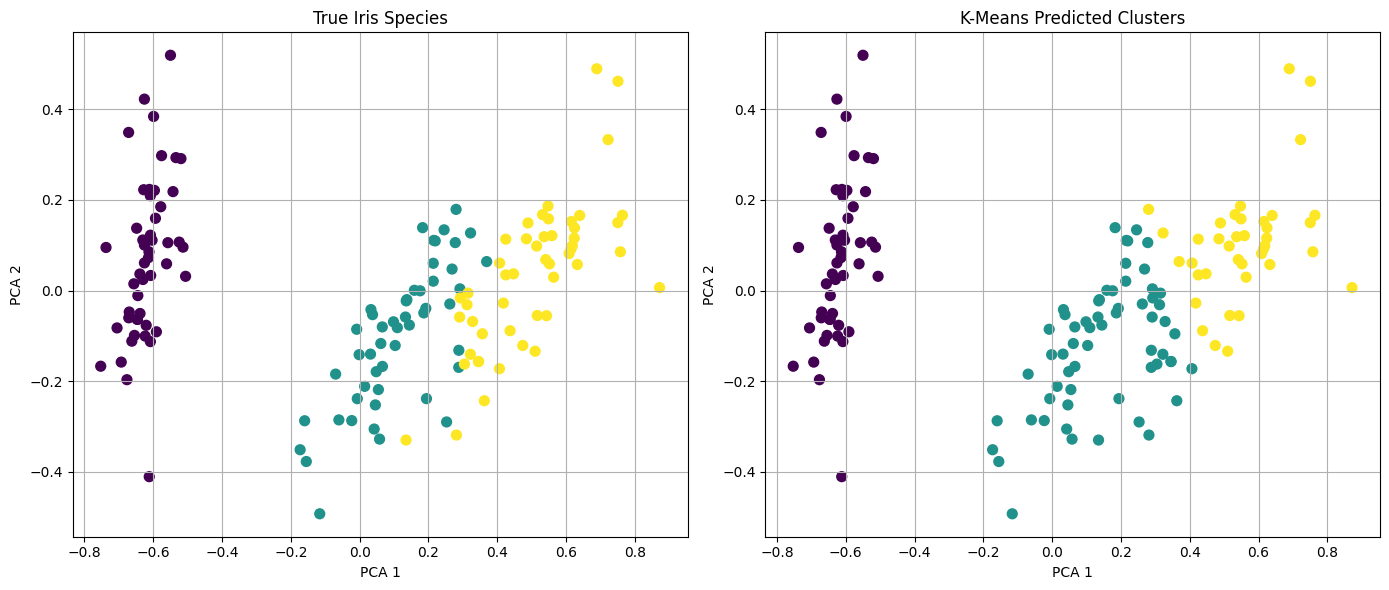

In [10]:
# Convert species names to numeric labels for coloring
from sklearn.preprocessing import LabelEncoder
true_labels = LabelEncoder().fit_transform(df['species'])

import matplotlib.pyplot as plt

x = [point[0] for point in reduced_data]
y = [point[1] for point in reduced_data]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Left: True labels
axs[0].scatter(x, y, c=true_labels, cmap='viridis', s=50)
axs[0].set_title("True Iris Species")
axs[0].set_xlabel("PCA 1")
axs[0].set_ylabel("PCA 2")
axs[0].grid(True)

# Right: K-Means predicted clusters
axs[1].scatter(x, y, c=cluster_labels, cmap='viridis', s=50)
axs[1].set_title("K-Means Predicted Clusters")
axs[1].set_xlabel("PCA 1")
axs[1].set_ylabel("PCA 2")
axs[1].grid(True)

plt.tight_layout()
plt.show()